In [2]:
!pip install yfinance
!pip install ta
!pip install mpl_finance

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import ta
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

In [10]:
#Funció de preprocessat si venim de meta trading 5

def preprocessing(name):
    df = pd.read_csv(name,delimiter="\t", index_col = "<DATE>", parse_dates = True).dropna()
    #Eliminem les dues ultimes columnes
    df = df.iloc[:,:-2]
    #Renombrem
    df.columns = ["open","high","low","close","volume"]
    df.index.name = "time"
    return df

In [12]:
#Funció de preprocessat si venim de yahoo

def preprocessing_yf(symbol):
    df = yf.download(symbol).dropna()
    df.columns = ["open","high","low","close","adj close","volume"]
    df.index.name = "time"
    del df["adj close"]
    return df

In [14]:
# Funció de característiques

def feature_engineering(df):
    df_copy = df.copy()
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window=14, fillna=False)
    df_copy["rsi"] = RSI.rsi()
    return df_copy

In [16]:
# Drawdown
def drawdown_function(serie):
    cum = serie.dropna().cumsum() + 1
    runing_max = np.maximum.accumulate(cum)
    drawdown = cum / runing_max - 1
    return drawdown

In [20]:
# Back Test
def BackTest(serie, annualized_scalar = 252):
    sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
    sp500.name = "SP500"
    val = pd.concat((return_serie, sp500),axis = 1).dropna()
    drawdown = drawdown_function(return_serie)
    max_drawdown = -np.min(drawdown)*100

    fig, (cum,dra) = plt.subplots(1,2,figsize=(20,6))
    fig.suptitle("Backtesting", size = 20)
    cum.plot(serie.cumsum()*100, color = "#39B3C7")
    cum.plot(val["SP500"].cumsum()*100, color = "#B85A0F")
    cum.legend(["Portfolio", "SP500"])
    cum.set_title("Cumulative Return ", size = 13)
    cum.set_ylabel("Cumulative Rerturn %", size = 11)
    plt.fill_between(drawdown.index, drawdown*100, 0, drawdown, color = "#CE5757", alpha = 0.65)
    plt.title("Drawdown")
    plt.ylabel("Drawdawn en %")
    plt.show()
    sortino = np.sqrt(annualized_scalar)* serie.mean()/serie.loc[serie<0].std()
    beta = np.cov(val[["return","SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)
    alpha = (annualized_scalar * (serie.mean() - beta * serie.mean()))

    print(f"Sortino : {np.round(sortino,3)}")
    print(f"Beta : {np.round(beta,3)}")
    print(f"Alpha : {np.round(alpha,3)} %")
    print(f"MaxDrawdown : {np.round(max_drawdown,3)} %")



In [39]:
def get_dataframe(input, mt5=False, yf=False):

    if mt5:
        df = preprocessing(input)
  
    if yf:
        df = preprocessing_yf(input)
    return df


In [49]:
currency = input("introdueix l'actiu a estudiar: ")
df = get_dataframe(currency, mt5=False, yf = True)
caracteristics = feature_engineering(df)
df.head()


introdueix l'actiu a estudiar:  GOOG


[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
time,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,184645512


In [51]:
caracteristics.head()

,open,high,low,close,volume,returns,SMA 15,SMA 60,MSD 10,MSD 30,rsi
time,,,,,,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,897427216,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-20,2.515820,2.716817,2.503118,2.697639,458857488,0.079430,NaN,NaN,NaN,NaN,NaN
2004-08-23,2.758411,2.826406,2.716070,2.724787,366857939,0.010064,NaN,NaN,NaN,NaN,NaN
2004-08-24,2.770615,2.779581,2.579581,2.611960,306396159,-0.041408,NaN,NaN,NaN,NaN,NaN
2004-08-25,2.614201,2.689918,2.587302,2.640104,184645512,0.010775,NaN,NaN,NaN,NaN,NaN


quin any vols visualitzar (o interval, ex. '2010:2015')?  2020


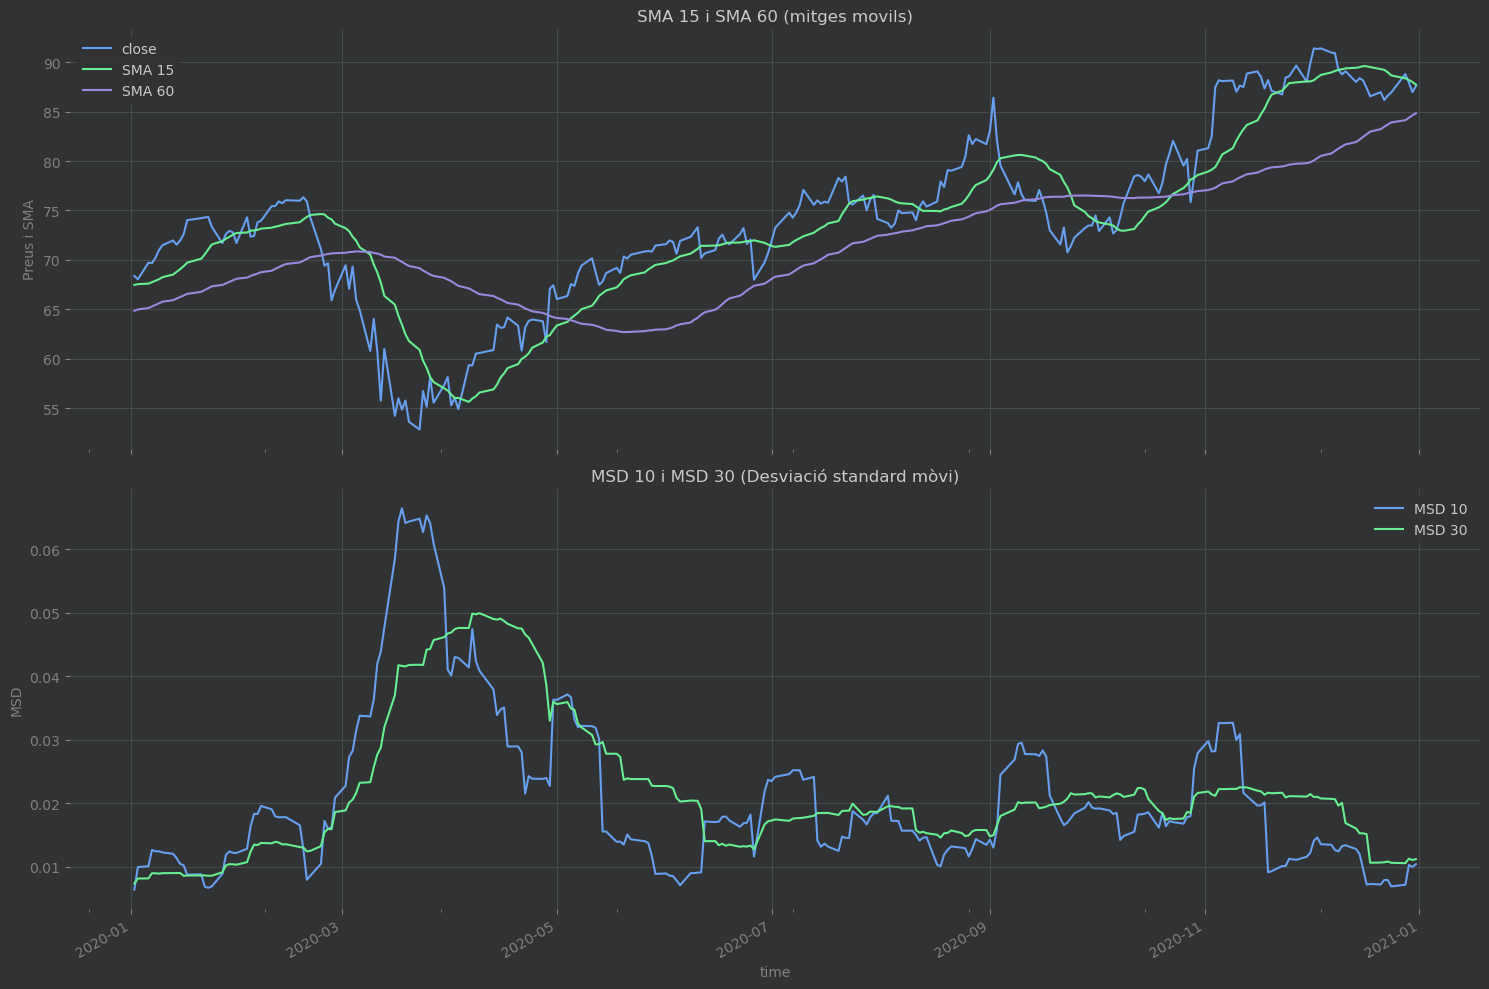

In [89]:
year = input("quin any vols visualitzar (o interval, ex. '2010:2015')? ")

# Comprovar si l'usuari ha introduït un interval (format: 'YYYY:YYYY')
if ':' in year:
    start_year, end_year = year.split(':')
    start_year = int(start_year.strip())
    end_year = int(end_year.strip())-1
    
    # Filtrar l'interval d'anys
    filtered_data = caracteristics[["close", "SMA 15", "SMA 60", "MSD 10", "MSD 30"]].loc[str(start_year):str(end_year)]
else:
    # Tractar-ho com un any únic
    filtered_data = caracteristics[["close", "SMA 15", "SMA 60","MSD 10", "MSD 30"]].loc[year]

# Plot de les dades filtrades
# Crear subplots, dos gràfics un sobre l'altre
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Primer gràfic per les SMA
filtered_data[["close", "SMA 15", "SMA 60"]].plot(ax=ax1)
ax1.set_title("SMA 15 i SMA 60 (mitges movils)")
ax1.set_ylabel("Preus i SMA")

# Segon gràfic per les MSD
filtered_data[["MSD 10", "MSD 30"]].plot(ax=ax2)
ax2.set_title("MSD 10 i MSD 30 (Desviació standard mòvi)")
ax2.set_ylabel("MSD")

# Mostrar els gràfics
plt.tight_layout()
plt.show()

